## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.6])
upper = np.array([0.1275, 1.1])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.76])


In [7]:
N_countsSimulator = n_counts_simulator.Model()

In [8]:
#N_data = N_countsSimulator.simulation(theta_fiducial, 1)
N_data = N_countsSimulator.N_counts
N_data

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

In [16]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))


## emcee

In [9]:
import numpy as np
import emcee
import corner

In [10]:
cov_matrix = np.diag(N_countsSimulator.N_counts)
cov_matrix_inv = np.linalg.inv(cov_matrix)
cov_matrix_inv.shape

(15, 15)

In [11]:
def log_prior(theta):
    omega_cdm = theta[0]
    sigma8 = theta[1]
    
    if 0.1125 < omega_cdm < 0.1275 and 0.6 < sigma8 < 1.1:
        return 0.0
    return -np.inf

def log_likelihood(theta, N_data):
    obs = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta)
    diff_temp = obs_temp - N_data
    return -0.5*np.dot(np.dot(diff_temp, cov_matrix_inv), diff_temp)
    

def log_probability(theta, N_data, seed):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, N_data)

In [12]:
# start at some point close to fiducial values
x_init = np.array([0.12, 0.762])

In [13]:
# create a small ball around the MLE the initialize each walker 
nwalkers, ndim = 30, 2
pos = x_init + 1e-4 * np.random.randn(nwalkers, ndim)

In [18]:
# run emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(N_data, 1))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [17:08:49<00:00, 12.35s/it]


In [19]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)


(9780, 2)


In [20]:
np.save('flat_samples_5000.npy', flat_samples)

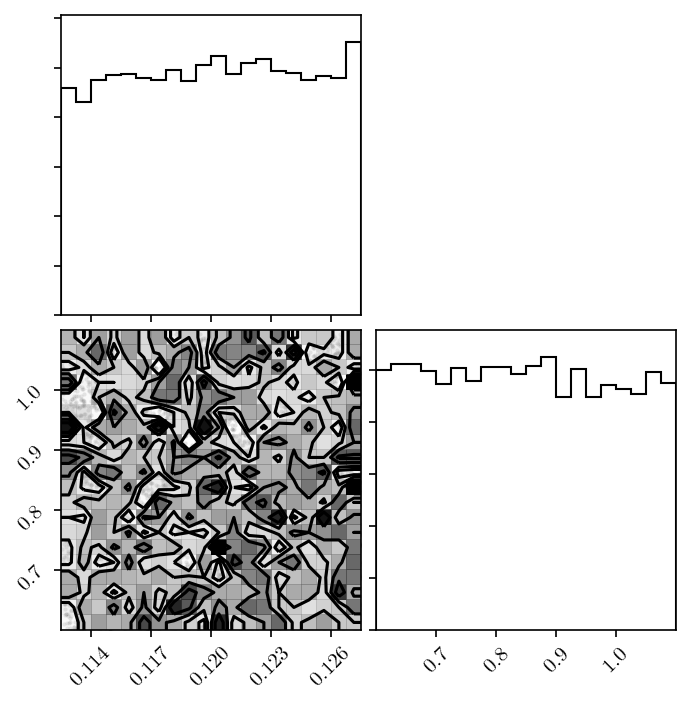

In [21]:
fig = corner.corner(flat_samples)